In [1]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.integrate import odeint
from ibm_nb_init import indep_init, ibm_init
from double_filter import *
from fenrir_filter import *
from jax.config import config
from filter_inference import filter_inference
from rodeo.kalmantv import predict, update

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
theta_diffrax = np.load('saves/fitz_theta_diffrax2.npy')
theta_kalman = np.load('saves/fitz_theta_kalman2.npy')[0:2]
config.update("jax_enable_x64", True)

In [2]:
def fitz0(X_t, t, theta):
    a, b, c = theta
    V, R = X_t 
    return np.array([c*(V - V*V*V/3 + R), -1/c*(V - a + b*R)])

def ode_fun(X, t, theta):
    "FitzHugh-Nagumo ODE function for jax."
    a, b, c = theta
    p = len(X)//2
    V, R = X[0], X[p]
    return jnp.array([c*(V - V*V*V/3 + R),
                      -1/c*(V - a + b*R)])

def ode_funpad(X, t, theta):
    a, b, c = theta
    p = len(X)//2
    V, R = X[0], X[p]
    return jnp.array([V, c*(V - V*V*V/3 + R), 0,
                      R, -1/c*(V - a + b*R), 0])


In [5]:
# problem setup and intialization
n_deriv = 1  # Total state
n_meas = 2  # Total measures
n_deriv_prior = 3
n_obs = 40
n_dim_obs = 2

n_order = jnp.array([n_deriv_prior]*n_meas)

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0.
tmax = 40.

# logprior parameters
theta_true = np.array([0.2, 0.2, 3]) # True theta
n_theta = len(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta) 

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = .1
sigma = jnp.array([sigma]*n_meas)

# Initial x0 for odeint
ode0 = np.array([-1., 1.])

# Initial x0 for jax
x0_block = jnp.array([[-1., 1., 0.], [1., 1/3, 0.]])
x0_state = x0_block.flatten()

# Initial W for jax non block
W = np.zeros((n_meas, jnp.sum(n_order)))
W[0, 1] = 1
W[1, n_deriv_prior+1] = 1
W = jnp.array(W)

key = jax.random.PRNGKey(0)

# observations
tseq1 = np.linspace(tmin, tmax, n_obs+1)
exact = odeint(fitz0, ode0, tseq1, args=(theta_true,))
gamma = .2
e_t = np.random.default_rng(100).normal(loc=0.0, scale=1, size=exact.shape)
y_obs = exact + gamma*e_t
mu_obs = jnp.zeros((n_dim_obs,))
wgt_obs = np.zeros((n_dim_obs, jnp.sum(n_order)))
wgt_obs[0,0] = 1
wgt_obs[1, n_deriv_prior] = 1
wgt_obs = jnp.array(wgt_obs)
var_obs = gamma**2*jnp.eye((n_dim_obs))

# jit double filter
df_jit = jax.jit(fenrir_filter, static_argnums=(0, 5))

In [ ]:
res_lst = np.array([15,20]) 
n_samples = 100000
# phi_init = jnp.log(theta_true)
phi_init = np.append(np.log(theta_true), ode0)
theta_filter = np.zeros((len(res_lst), n_samples, n_theta+2))
for r,n_res in enumerate(res_lst):
    n_eval = n_obs*n_res
    y_out = jnp.ones((n_eval+1, n_dim_obs))*jnp.nan
    for i in range(n_obs+1):
        y_out = y_out.at[i*n_res].set(y_obs[i])

    # Get parameters for non block
    dt = (tmax-tmin)/n_eval
    ode_init = ibm_init(dt, n_order, sigma)
    kinit = indep_init(ode_init, n_order)
    ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())
    
    inf = filter_inference(key, tmin, tmax, ode_fun)
    inf.W = W
    inf.mu_state = ode_init['mu_state']
    inf.wgt_state = ode_init['wgt_state']
    inf.var_state = ode_init['var_state']
    inf.mu_obs = mu_obs
    inf.wgt_obs = wgt_obs
    inf.var_obs = var_obs
    inf.funpad = ode_funpad

    phi_hat, phi_var, phi_fisher = inf.phi_fit(y_out, np.array([None, None]), phi_mean, phi_sd, phi_init, inf.double_filter_nlpost,
                                               double=True, varzero=True)
    
    theta_filter[r] = inf.phi_sample(phi_hat, phi_var, n_samples)
    theta_filter[r, :, :n_theta] = np.exp(theta_filter[r, :, :n_theta])
# np.save('saves/fitz_theta_filter.npy', theta_filter)

In [6]:
plt.rcParams.update({'font.size': 20})
# var_names = ['a', 'b', 'c']
var_names = ['a', 'b', 'c', r"$V_0^{(0)}$", r"$R_0^{(0)}$"]
param_true = np.append(theta_true, np.array([-1, 1]))

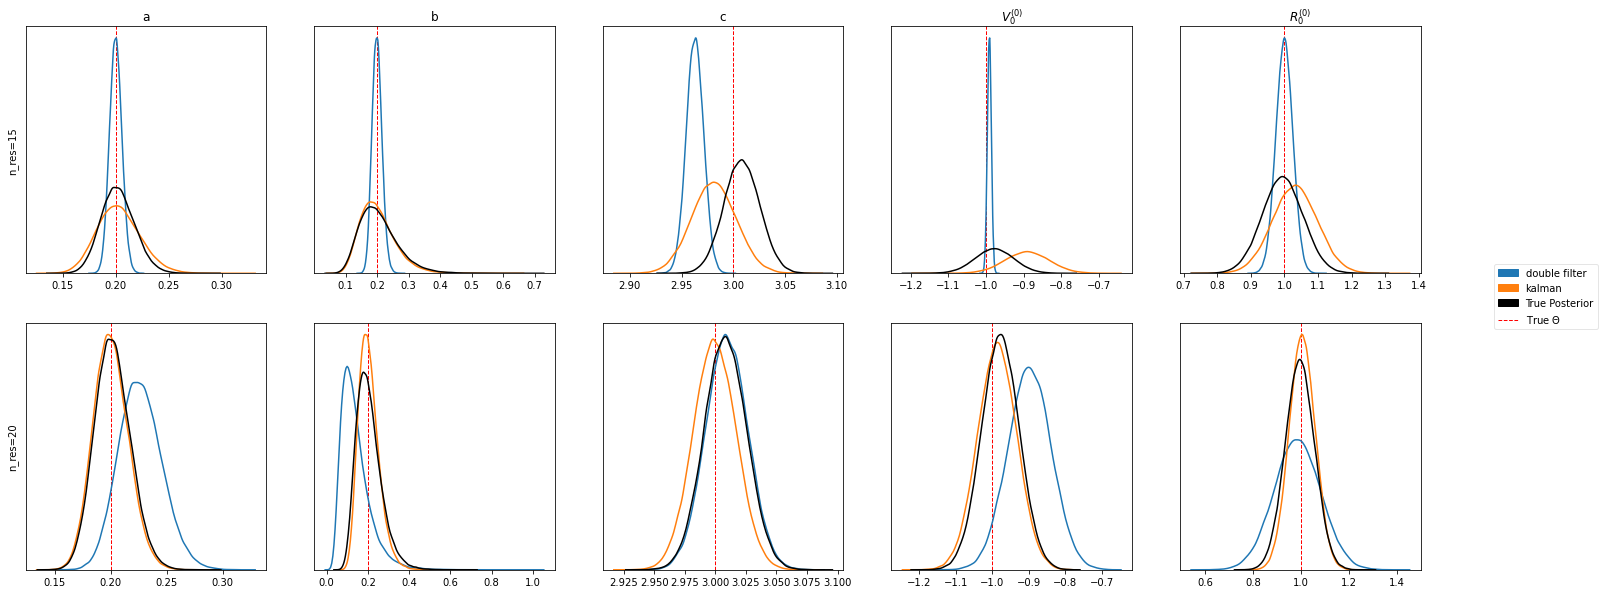

In [8]:
n_row = len(res_lst)
fig, axs = plt.subplots(n_row, 5, figsize=(25, 5*n_row))
for r in range(n_row):
    for i in range(theta_filter.shape[-1]):
        axs[r,i].axvline(x=param_true[i], linewidth=1, color='r', linestyle='dashed')
        sns.kdeplot(theta_filter[r, :, i], ax=axs[r,i])
        sns.kdeplot(theta_kalman[r, :, i], ax=axs[r,i])
        sns.kdeplot(theta_diffrax[:, i], ax=axs[r,i], color='black')
        axs[r,i].set(ylabel=None,yticks=[])
        if r==0:
            axs[r, i].set(title=var_names[i])
    axs[r,0].set(ylabel='n_res={}'.format(res_lst[r]))
    
patches = [None]*4
patches[0] = mpatches.Patch(color='C0', label='double filter')
patches[1] = mpatches.Patch(color='C1', label='kalman')
patches[2] = mpatches.Patch(color='black', label="True Posterior")
patches[3] = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1, label='True $\\Theta$')
fig.legend(handles=patches, framealpha=0.5, loc=7)
# fig.tight_layout()

In [14]:
res_lst = np.array([10, 20]) 
n_samples = 100000
# phi_init = jnp.log(theta_true)
phi_init = np.append(np.log(theta_true), ode0)
theta_filter = np.zeros((len(res_lst), n_samples, n_theta+2))
for r,n_res in enumerate(res_lst):
    n_eval = n_obs*n_res
    y_out = jnp.ones((n_eval+1, n_dim_obs))*jnp.nan
    for i in range(n_obs+1):
        y_out = y_out.at[i*n_res].set(y_obs[i])

    # Get parameters for non block
    dt = (tmax-tmin)/n_eval
    ode_init = ibm_init(dt, n_order, sigma)
    kinit = indep_init(ode_init, n_order)
    ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())
    
    inf = filter_inference(key, tmin, tmax, ode_fun)
    inf.W = W
    inf.mu_state = ode_init['mu_state']
    inf.wgt_state = ode_init['wgt_state']
    inf.var_state = ode_init['var_state']
    inf.mu_obs = mu_obs
    inf.wgt_obs = wgt_obs
    inf.var_obs = var_obs
    inf.funpad = ode_funpad

    phi_hat, phi_var, phi_fisher = inf.phi_fit(y_out, np.array([None, None]), phi_mean, phi_sd, phi_init, inf.fenrir_nlpost)
    
    theta_filter[r] = inf.phi_sample(phi_hat, phi_var, n_samples)
    theta_filter[r, :, :n_theta] = np.exp(theta_filter[r, :, :n_theta])
# np.save('saves/fitz_theta_filter.npy', theta_filter)

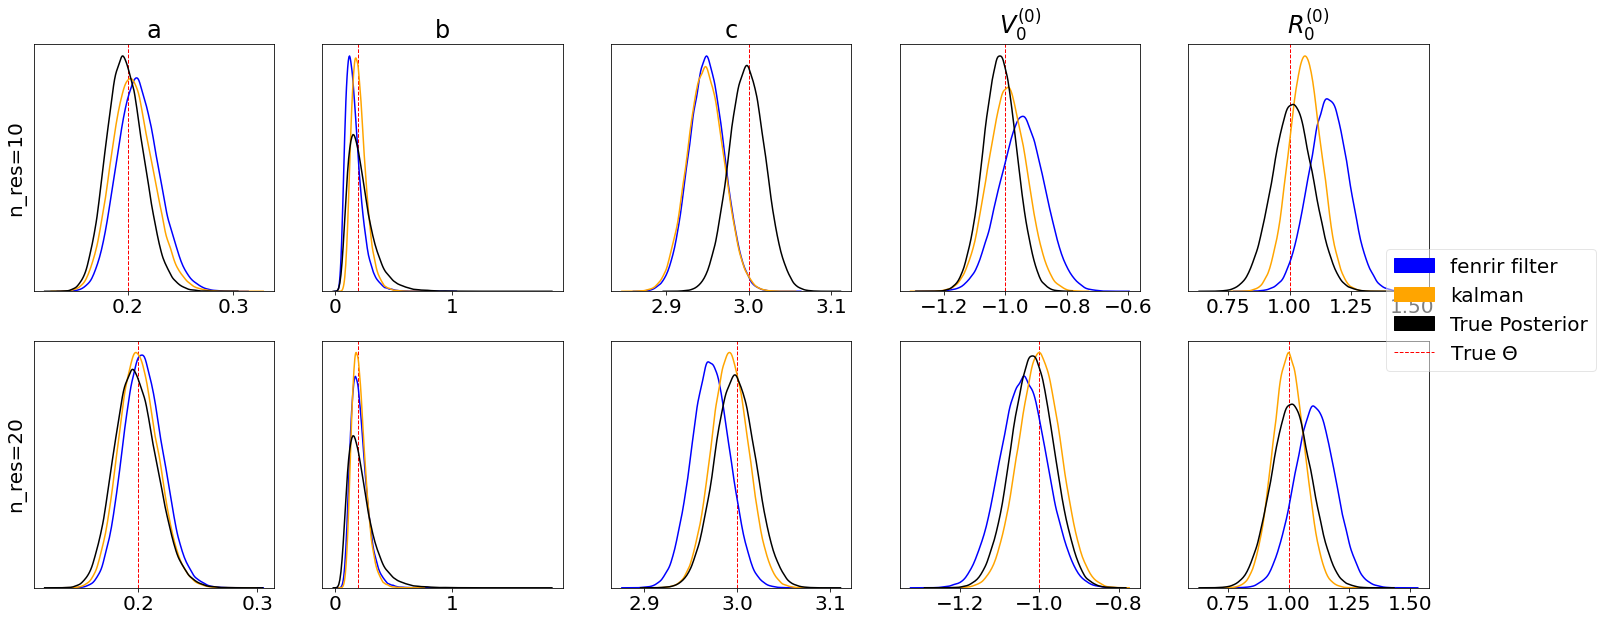

In [15]:
n_row = len(res_lst)
fig, axs = plt.subplots(n_row, 5, figsize=(25, 5*n_row))
for r in range(n_row):
    for i in range(theta_filter.shape[-1]):
        axs[r,i].axvline(x=param_true[i], linewidth=1, color='r', linestyle='dashed')
        sns.kdeplot(theta_filter[r, :, i], ax=axs[r,i], color="blue")
        sns.kdeplot(theta_kalman[r, :, i], ax=axs[r,i], color="orange")
        sns.kdeplot(theta_diffrax[:, i], ax=axs[r,i], color='black')
        axs[r,i].set(ylabel=None,yticks=[])
        if r==0:
            axs[r, i].set(title=var_names[i])
    axs[r,0].set(ylabel='n_res={}'.format(res_lst[r]))
    
patches = [None]*4
patches[0] = mpatches.Patch(color='blue', label='fenrir filter')
patches[1] = mpatches.Patch(color='orange', label='kalman')
patches[2] = mpatches.Patch(color='black', label="True Posterior")
patches[3] = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1, label='True $\\Theta$')
fig.legend(handles=patches, framealpha=0.5, loc=7)
# fig.tight_layout()

In [6]:
ng_jit = jax.jit(fenrir_filterng, static_argnums=(0, 5, 13,14))

In [8]:
def obs_fun(y, Cx, gamma, theta):
    mu_obs, var_obs = gamma
    mu = Cx + mu_obs
    return jsp.stats.multivariate_normal.logpdf(y, mu, var_obs)
def x_fun(x, y, theta):
    return x

In [9]:
n_res = 5
n_eval = n_obs*n_res
dt = (tmax-tmin)/n_eval
ode_init = ibm_init(dt, n_order, sigma)
kinit = indep_init(ode_init, n_order)
ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())

In [9]:
y_out = jnp.ones((n_eval+1, n_dim_obs))*jnp.nan
x_out = jnp.ones((n_eval+1, len(x0_state)))*jnp.nan
for i in range(n_obs+1):
    y_out = y_out.at[i*n_res].set(y_obs[i])
    x_out = x_out.at[i*n_res].set(jnp.zeros(len(x0_state)))

In [10]:
df_jit(ode_fun, x0_state, theta_true, tmin, tmax, n_res, W,
       ode_init["wgt_state"], ode_init["mu_state"], ode_init["var_state"],
       wgt_obs, mu_obs, var_obs, y_obs)

DeviceArray(-543.96708026, dtype=float64)

In [11]:
ng_jit(ode_fun, x0_state, theta_true, tmin, tmax, n_res, W,
       ode_init["wgt_state"], ode_init["mu_state"], ode_init["var_state"],
       wgt_obs, y_obs, (mu_obs, var_obs), obs_fun, x_fun)

TypeError: Incompatible shapes for dot: got (2, 6) and (2,).

In [ ]:
n_row = len(res_lst)
fig, axs = plt.subplots(n_row, 5, figsize=(25, 5*n_row))
for r in range(n_row):
    for i in range(theta_filter.shape[-1]):
        axs[r,i].axvline(x=param_true[i], linewidth=1, color='r', linestyle='dashed')
        sns.kdeplot(theta_filter[r, :, i], ax=axs[r,i])
        sns.kdeplot(theta_kalman[r, :, i], ax=axs[r,i])
        sns.kdeplot(theta_diffrax[:, i], ax=axs[r,i], color='black')
        axs[r,i].set(ylabel=None,yticks=[])
        if r==0:
            axs[r, i].set(title=var_names[i])
    axs[r,0].set(ylabel='n_res={}'.format(res_lst[r]))
    
patches = [None]*4
patches[0] = mpatches.Patch(color='C0', label='fenrir filter')
patches[1] = mpatches.Patch(color='C1', label='kalman')
patches[2] = mpatches.Patch(color='black', label="True Posterior")
patches[3] = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1, label='True $\\Theta$')
fig.legend(handles=patches, framealpha=0.5, loc=7)
# fig.tight_layout()

In [18]:
import numpy as np
import jax
import jax.numpy as jnp
from scipy.integrate import odeint
from ibm_init import indep_init, ibm_init
from double_filter import *
from jax.config import config
from filter_inference import filter_inference

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
theta_diffrax = np.load('saves/lin_theta_diffrax.npy')
theta_kalman = np.load('saves/lin_theta_kalman.npy')
config.update("jax_enable_x64", True)

In [19]:
def linode0(X_t, t, theta):
    a, b = theta
    x1, x2 = X_t
    return np.array([a*x1, b*x2])

def linode(X_t, t, theta):
    "FitzHugh-Nagumo ODE function for jax."
    a, b = theta
    p = len(X_t)//2
    x1, x2 = X_t[0], X_t[p]
    return jnp.array([a*x1, b*x2])

def ode_funpad(X_t, t, theta):
    a, b = theta
    p = len(X_t)//2
    x1, x2 = X_t[0], X_t[p]
    return jnp.array([x1, a*x1, 0,
                      x2, b*x2, 0])


In [20]:
# problem setup and intialization
n_deriv = 1  # Total state
n_meas = 2  # Total measures
n_deriv_prior = 3
n_obs = 40
n_dim_obs = 2

n_order = jnp.array([n_deriv_prior]*n_meas)

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0.
tmax = 40.

# logprior parameters
theta_true = np.array([0.2, 0.3]) # True theta
n_theta = len(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta) 

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = .1
sigma = jnp.array([sigma]*n_meas)

# Initial x0 for odeint
ode0 = np.array([-1., 1.])

# Initial x0 for jax
x0_block = jnp.array([[-1., 0.2, 0.], [1., 0.3, 0.]])
x0_state = x0_block.flatten()

# Initial W for jax non block
W = np.zeros((n_meas, jnp.sum(n_order)))
W[0, 1] = 1
W[1, n_deriv_prior+1] = 1
W = jnp.array(W)

key = jax.random.PRNGKey(0)

# observations
tseq1 = np.linspace(tmin, tmax, n_obs+1)
exact = odeint(linode0, ode0, tseq1, args=(theta_true,))
gamma = 1
e_t = np.random.default_rng(0).normal(loc=0.0, scale=1, size=exact.shape)
y_obs = exact + gamma*e_t
mu_obs = jnp.zeros((n_dim_obs,))
wgt_obs = np.zeros((n_dim_obs, jnp.sum(n_order)))
wgt_obs[0,0] = 1
wgt_obs[1, n_deriv_prior] = 1
wgt_obs = jnp.array(wgt_obs)
var_obs = gamma**2*jnp.eye((n_dim_obs))

# jit double filter
df_jit = jax.jit(double_ode_filter, static_argnums=(1, 14, 15))

In [16]:
res_lst = np.array([1, 2]) 
n_samples = 100000
# phi_init = jnp.log(theta_true)
phi_init = np.append(np.log(theta_true), ode0)
theta_filter = np.zeros((len(res_lst), n_samples, n_theta+2))
for r,n_res in enumerate(res_lst):
    n_eval = n_obs*n_res
    y_out = jnp.ones((n_eval+1, n_dim_obs))*jnp.nan
    for i in range(n_obs+1):
        y_out = y_out.at[i*n_res].set(y_obs[i])

    # Get parameters for non block
    dt = (tmax-tmin)/n_eval
    ode_init = ibm_init(dt, n_order, sigma)
    kinit = indep_init(ode_init, n_order)
    ode_init = dict((k, jnp.array(v)) for k, v in kinit.items())
    
    inf = filter_inference(key, tmin, tmax, linode)
    inf.W = W
    inf.mu_state = ode_init['mu_state']
    inf.wgt_state = ode_init['wgt_state']
    inf.var_state = ode_init['var_state']
    inf.mu_obs = mu_obs
    inf.wgt_obs = wgt_obs
    inf.var_obs = var_obs
    inf.funpad = ode_funpad

    phi_hat, phi_var, phi_fisher = inf.phi_fit(y_out, np.array([None, None]), phi_mean, phi_sd, phi_init, double=True, varzero=False)
    
    theta_filter[r] = inf.phi_sample(phi_hat, phi_var, n_samples)
    theta_filter[r, :, :n_theta] = np.exp(theta_filter[r, :, :n_theta])
np.save('saves/lin_theta_filterTF.npy', theta_filter)

In [21]:
plt.rcParams.update({'font.size': 20})

var_names = ['a', 'b', r"$x_0^{(0)}$", r"$y_0^{(0)}$"]
param_true = np.append(theta_true, np.array([-1, 1]))

In [22]:
theta_filter1 = np.load('saves/lin_theta_filterTT.npy')
theta_filter2 = np.load('saves/lin_theta_filterTF.npy')
theta_filter3 = np.load('saves/lin_theta_filterFT.npy')
theta_filter4 = np.load('saves/lin_theta_filterFF.npy')


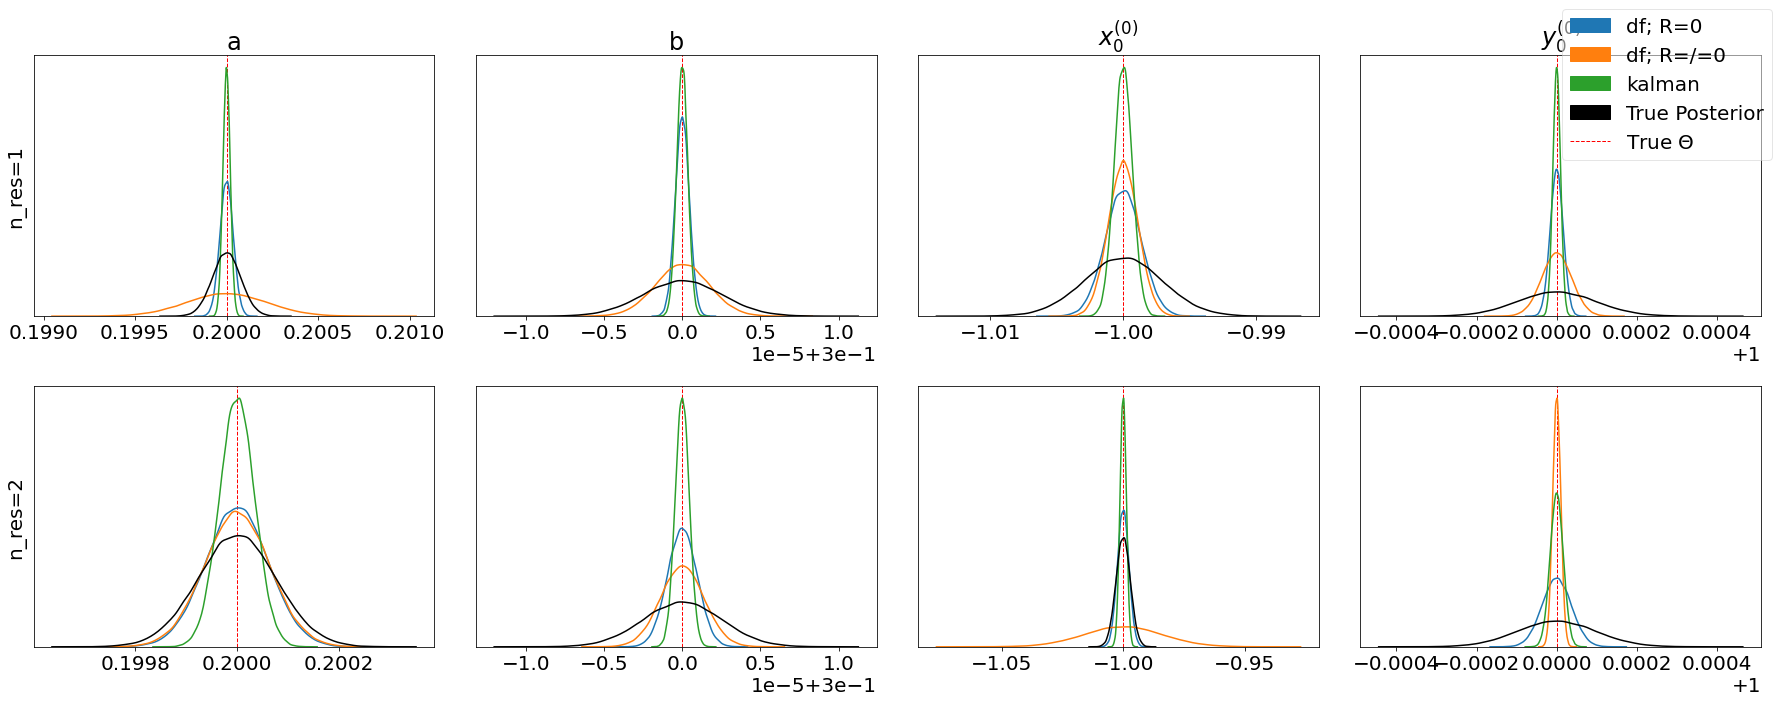

In [24]:
res_lst = np.array([1, 2]) 
n_row = len(res_lst)
fig, axs = plt.subplots(n_row, 4, figsize=(25, 5*n_row))
for r in range(n_row):
    for i in range(theta_filter1.shape[-1]):
        axs[r,i].axvline(x=param_true[i], linewidth=1, color='r', linestyle='dashed')
        sns.kdeplot(theta_filter1[r, :, i], ax=axs[r,i])
        sns.kdeplot(theta_filter2[r, :, i], ax=axs[r,i])
#         sns.kdeplot(theta_filter3[r, :, i], ax=axs[r,i])
#         sns.kdeplot(theta_filter4[r, :, i], ax=axs[r,i])
        sns.kdeplot(theta_kalman[r, :, i], ax=axs[r,i])
        sns.kdeplot(theta_diffrax[:, i], ax=axs[r,i], color='black')
        axs[r,i].set(ylabel=None,yticks=[])
        if r==0:
            axs[r, i].set(title=var_names[i])
    axs[r,0].set(ylabel='n_res={}'.format(res_lst[r]))
    
patches = [None]*5
patches[0] = mpatches.Patch(color='C0', label='df; R=0')
patches[1] = mpatches.Patch(color='C1', label='df; R=/=0')
# patches[2] = mpatches.Patch(color='C2', label='sf; R=0')
# patches[3] = mpatches.Patch(color='C3', label='sf; R=/=0')
patches[2] = mpatches.Patch(color='C2', label='kalman')
patches[3] = mpatches.Patch(color='black', label="True Posterior")
patches[4] = mlines.Line2D([], [], color='r', linestyle='dashed', linewidth=1, label='True $\\Theta$')
fig.tight_layout()
fig.legend(handles=patches, framealpha=0.5)


In [4]:
import numpy as np
import matplotlib.pyplot as plt
import jax
import jax.numpy as jnp

from inference.lininf import lininf as inference
from rodeo.ibm_init import ibm_init as bibm_init
from rodeo.ode_solve import *

def linblock(X_t, t, theta):
    "Fitz ODE written for jax"
    a, b = theta
    x1, x2 = X_t[:, 0]
    return jnp.array([[a*x1],
                      [b*x2]])

def linblockpad(X_t, t, theta):
    a, b = theta
    p = len(X_t)//2
    x1, x2 = X_t[0], X_t[p]
    return jnp.array([[x1, a*x1, 0],
                      [x2, b*x2, 0]])


n_deriv = 1 # number of derivatives in IVP
n_obs = 2 # number of observations.
n_deriv_prior = 3 # number of derivatives in IBM prior

# it is assumed that the solution is sought on the interval [tmin, tmax].
tmin = 0.
tmax = 40.

# The rest of the parameters can be tuned according to ODE
# For this problem, we will use
sigma = jnp.array([.1]*n_obs)
n_order = jnp.array([n_deriv_prior]*n_obs)

# Initial value, x0, for the IVP
x0 = np.array([-1., 1.])
v0 = np.array([-0.2, 0.3])
X0 = np.ravel([x0, v0], 'F')

# pad the inputs
W_mat = np.zeros((n_obs, 1, n_deriv_prior))
W_mat[:, :, 1] = 1
W = jnp.array(W_mat)

# logprior parameters
theta_true = np.array([0.2, .3]) # True theta
n_theta = len(theta_true)
phi_mean = np.zeros(n_theta)
phi_sd = np.log(10)*np.ones(n_theta) 

# Observation noise
gamma = 1

# Number of samples to draw from posterior
n_samples = 100000

# Initialize inference class and simulate observed data
key = jax.random.PRNGKey(0)
inf = inference(key, tmin, tmax, linblock)
inf.funpad = linblockpad
    
dtlst = np.array([1, 0.5])
obs_t = 1
# Parameter inference using Kalman solver
theta_kalman = np.zeros((len(dtlst), n_samples, n_theta+n_obs))
phi_init = np.append(np.log(theta_true), ode0)
# for i in range(len(dtlst)):
#     kinit = bibm_init(dtlst[i], n_order, sigma)
#     n_eval = int((tmax-tmin)/dtlst[i])
#     inf.n_eval = n_eval
#     inf.kinit = kinit
#     inf.W = W
#     phi_hat, phi_var = inf.phi_fit(y_obs, np.array([None, None]), dtlst[i], obs_t, phi_mean, phi_sd, inf.kalman_nlpost,
#                                    gamma, phi_init = phi_init)
#     theta_kalman[i] = inf.phi_sample(phi_hat, phi_var, n_samples)
#     theta_kalman[i, :, :n_theta] = np.exp(theta_kalman[i, :, :n_theta])
# np.save('saves/lin_theta_kalman.npy', theta_kalman)

# Parameter inference using diffrax
phi_hat, phi_var = inf.phi_fit(y_obs, np.array([None, None]), obs_t, obs_t, phi_mean, phi_sd, inf.diffrax_nlpost,
                              gamma, phi_init = phi_init)
theta_diffrax = inf.phi_sample(phi_hat, phi_var, n_samples)
theta_diffrax[:, :n_theta] = np.exp(theta_diffrax[:, :n_theta])
np.save('saves/lin_theta_diffrax2.npy', theta_diffrax)

